In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from piecewise import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [5]:
tf.enable_eager_execution()

In [6]:
test = PiecewiseLinear(6,3,5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
_________________________________________________________________
reshape (Reshape)            (None, 3, 5)              0         
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [21]:
val = np.array(np.random.rand(1000000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [26]:
np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1))

False

In [11]:
test = PiecewiseQuadratic(6,3,5)

In [20]:
val = np.array(np.random.rand(1000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


## Training

In [27]:
tf.disable_eager_execution()

In [3]:
bijectors = []

for i in range(4):
    bijectors.append(PiecewiseLinear(2,1,5,layer_id=i))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
test_bijector.forward_min_event_ndims

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
_________________________________________________________________
reshape (Reshape)            (None, 1, 5)              0         
Total params: 4,613
Trainable params: 4,613
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
La

1

In [4]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
    event_shape=[1],
)

In [5]:
x = base_dist.sample(1000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

Tensor("PiecewiseLinear/forward/transpose:0", shape=(1000, 1, 2), dtype=int32)
Tensor("PiecewiseLinear/forward/strided_slice_3:0", shape=(1000, 1, 1), dtype=int32)
Tensor("PiecewiseLinear_1/forward/transpose:0", shape=(1000, 1, 2), dtype=int32)
Tensor("PiecewiseLinear_1/forward/strided_slice_3:0", shape=(1000, 1, 1), dtype=int32)
Tensor("PiecewiseLinear_2/forward/transpose:0", shape=(1000, 1, 2), dtype=int32)
Tensor("PiecewiseLinear_2/forward/strided_slice_3:0", shape=(1000, 1, 1), dtype=int32)
Tensor("PiecewiseLinear_3/forward/transpose:0", shape=(1000, 1, 2), dtype=int32)
Tensor("PiecewiseLinear_3/forward/strided_slice_3:0", shape=(1000, 1, 1), dtype=int32)


In [6]:
sess = tf.InteractiveSession()

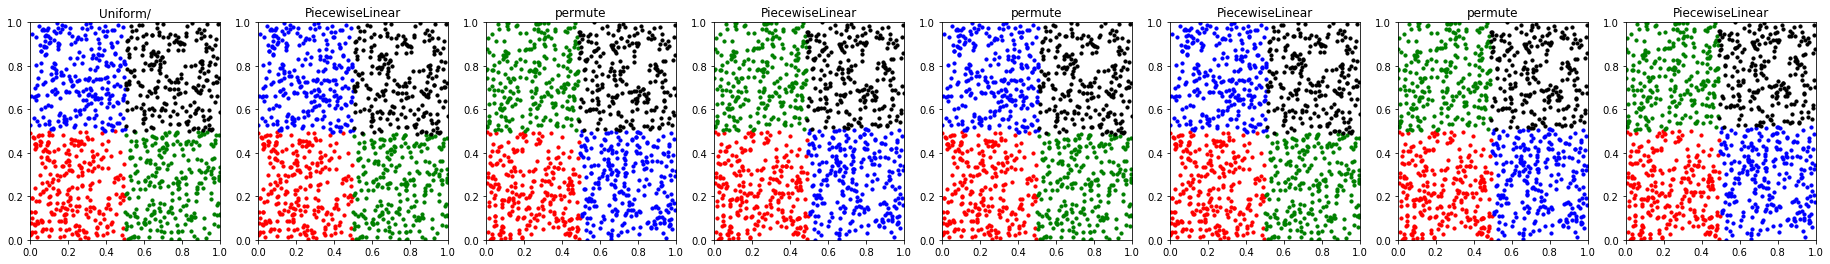

In [7]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [8]:
def dsigma(x):
    return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))

In [9]:
x = sess.run(dist.sample(1000))
X = sess.run(dist.log_prob(x))
dsig = sess.run(dsigma(x))
print(tf.reduce_prod(X,axis=-1), '\n', dsig)

Tensor("chain_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinearUniform/sample/chain_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear/forward/PiecewiseLinear/forward/transpose:0", shape=(1000, 1, 2), dtype=int32)
Tensor("chain_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinearUniform/sample/chain_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear/forward/PiecewiseLinear/forward/strided_slice_3:0", shape=(1000, 1, 1, 1), dtype=int32)


ValueError: Shape must be rank 3 but is rank 4 for 'chain_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinearUniform/sample/chain_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear_of_permute_of_PiecewiseLinear/forward/PiecewiseLinear/forward/concat' (op: 'ConcatV2') with input shapes: [1000,1,2], [1000,1,1,1], [].

In [12]:
print(dist._maybe_get_static_event_ndims())
print(dist.event_shape)
print(sess.run(tf.transpose(tf.meshgrid(tf.range(1000)),bijectors[0].range)))

1
(1,)


ValueError: Dimension must be 2 but is 1 for 'transpose' (op: 'Transpose') with input shapes: [1,1000], [1].

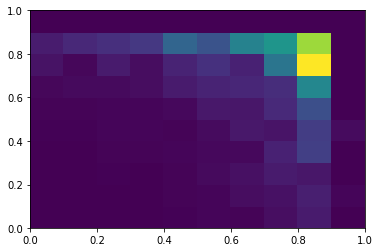

In [16]:
plt.hist2d(x[:,0],x[:,1],weights=dsig)
plt.show()

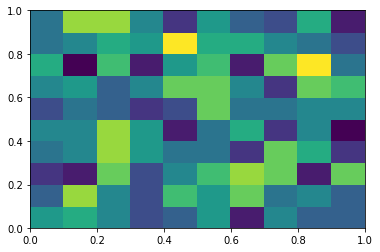

In [13]:
plt.hist2d(x[:,0],x[:,1])
plt.show()

In [12]:
loss = -sess.run(tf.reduce_mean(dsig*tf.log(tf.reduce_prod(X,axis=-1))))
print(loss)

2.1379054


In [13]:
def loss_fn():
    x = dist.sample(200)
    logq = tf.reduce_sum(tf.log(bijector.pdf(x)),axis=-1)
    p = dsigma(x)
    return -tf.reduce_mean(p*logq)

In [14]:
def grad():
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [15]:
loss = loss_fn()
optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


0 2.3814147


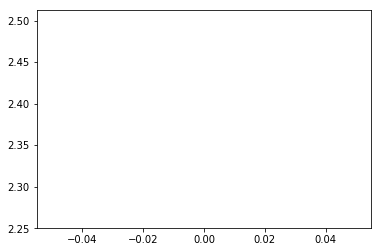

In [16]:
np_losses = []
global_step = []
for epoch in range(1000):
    _, np_loss = sess.run([optimizer, loss])
    if epoch % 1000 == 0:
        global_step.append(epoch)
        np_losses.append(np_loss)
        print(epoch, np_loss)
        
start = 0
plt.plot(np_losses[start:])

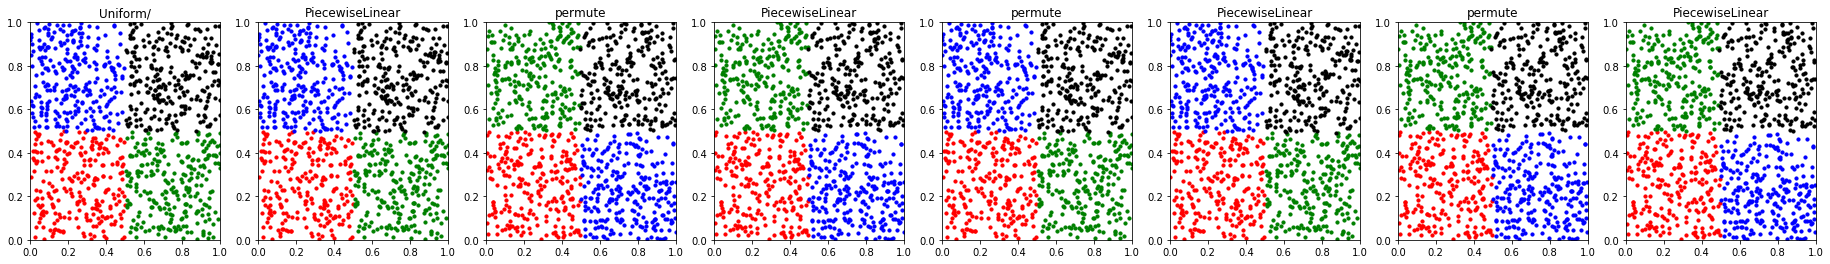

In [16]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [17]:
X = sess.run(dist.sample(1000))
x = sess.run(bijector.pdf(X))
dsig = sess.run(dsigma(X))
print(tf.reduce_prod(x,axis=-1), '\n', dsig)

Tensor("Prod_2:0", shape=(1000,), dtype=float32) 
 [6.62698090e-01 1.03224795e-02 0.00000000e+00 1.50914586e+00
 3.01949954e+00 4.31630909e-01 9.63923931e+00 3.87851024e+00
 1.15991983e+01 0.00000000e+00 1.97158642e+01 0.00000000e+00
 5.65296602e+00 1.44837368e+00 2.13169308e+01 9.24625683e+00
 6.30533266e+00 1.08651280e+00 3.11764026e+00 3.72917366e+00
 0.00000000e+00 0.00000000e+00 8.12208593e-01 5.48033476e+00
 4.82503319e+00 1.99654520e+00 2.83356190e+00 4.90360355e+00
 4.28337669e+01 3.69880080e+00 7.14454889e+00 3.35862656e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.97500753e+00
 0.00000000e+00 3.11757755e+00 4.86936748e-01 2.25556064e+00
 0.00000000e+00 1.38615966e+00 4.96453077e-01 1.19449987e+01
 2.76821870e-02 2.71028209e+00 8.71170712e+00 8.21238339e-01
 1.04057384e+00 1.62978888e+00 3.68216438e+01 7.19235945e+00
 0.00000000e+00 1.09445739e+00 1.13500762e+00 5.47888336e+01
 5.55394459e+00 9.35147476e+00 2.07090881e-02 1.45540762e+00
 4.57209200e-01 1.91138721e+00 6.8

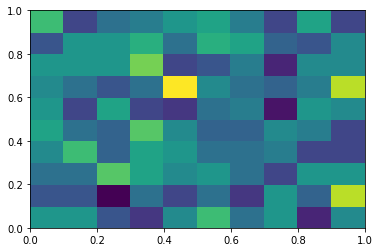

In [18]:
plt.hist2d(X[:,0],X[:,1])
plt.show()

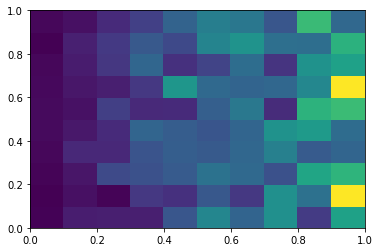

In [19]:
weights = sess.run(tf.reduce_prod(x,axis=-1))
plt.hist2d(X[:,0],X[:,1],weights=weights)
plt.show()

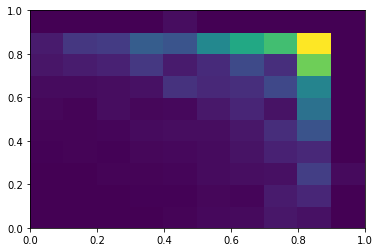

In [20]:
plt.hist2d(X[:,0],X[:,1],weights=dsig)
plt.show()

In [21]:
sess.run(tf.reduce_mean(dsig/tf.reduce_prod(x,axis=-1)))

21.130308

In [22]:
def dsigma_np(x1,x2):
    return (x1**2 + x2**2)/((1-x1)*(1-x2))

In [23]:
import scipy.integrate as integrate

print(integrate.dblquad(dsigma_np,0.0,0.9,0.0,0.9))

(4.594049128242379, 3.1928194812308724e-07)


In [24]:
dist.log_prob(x)

ValueError: event_ndims (0) must be larger than min_event_ndims (1)

In [25]:
dist._maybe_get_static_event_ndims()

0

In [28]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

# A common choice for a normalizing flow is to use a Gaussian for the base
# distribution. (However, any continuous distribution would work.) E.g.,
nvp = tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
      bijector=tfb.RealNVP(
          num_masked=2,
          shift_and_log_scale_fn=tfb.real_nvp_default_template(
              hidden_layers=[512, 512])))
x = nvp.sample(10)
nvp.log_prob(x)
nvp.log_prob(0.)

ValueError: Index out of range using input dim 0; input has only 0 dims for 'real_nvpMultivariateNormalDiag_2/log_prob_1/real_nvp/inverse/strided_slice' (op: 'StridedSlice') with input shapes: [], [2], [2], [2] and with computed input tensors: input[3] = <1 1>.

In [29]:
sess.run(tf.global_variables_initializer())
sess.run(nvp.log_prob(x))

array([-2.9377754, -2.8155026, -4.5215673, -3.1288712, -3.5845277,
       -4.230508 , -3.051555 , -3.9338195, -3.4340785, -3.3578875],
      dtype=float32)